In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('data_analyze/training_dataset_2_redundancy.csv')
df.head()

,filename,labels,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,...,patient_label,z_axis,slice_thickness,selected_indices,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid
0,"['ID_37f32aed2.dcm', 'ID_d61a6a7b9.dcm', 'ID_4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0002cd41,ID_66929e09d4,...,0,"[38.484, 43.517, 48.549, 53.582, 58.614, 63.64...","[2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.52, 2.5...","[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 18, 19, 20...",0,0,0,0,0,0
1,"['ID_138d275c8.dcm', 'ID_447fa09d9.dcm', 'ID_0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00054f3f,ID_8a449ae31b,...,0,"[71.9000244, 76.9000244, 81.9000244, 86.900024...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0,0,0,0,0
2,"['ID_520df89aa.dcm', 'ID_3b87d36d0.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0006d192,ID_25690b4725,...,0,"[41.921, 49.421, 56.921, 64.421, 71.921, 79.42...","[3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.7...","[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25...",0,0,0,0,0,0
3,"['ID_203ef1efe.dcm', 'ID_0cec86087.dcm', 'ID_1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00086119,ID_fdde2979b0,...,0,"[35.556, 40.757, 45.959, 51.16, 56.362, 61.563...","[2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, ...","[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 20, 21, 22...",0,0,0,0,0,0
4,"['ID_0785539ea.dcm', 'ID_30c100dbc.dcm', 'ID_3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_000e5623,ID_9a4be35b9a,...,0,"[272.0, 277.0, 282.0, 287.0, 292.0, 297.0, 302...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0,0,0,0,0


In [15]:
# Define target columns with patient_ prefix
target_cols = [
    'patient_any',
    'patient_subdural',
    'patient_epidural',
    'patient_intraparenchymal',
    'patient_intraventricular',
    'patient_subarachnoid'
]

# Filter and verify columns exist
patient_df = df[target_cols]

# Basic statistics
summary = patient_df.describe()
summary

,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid
count,21735.000000,21735.000000,21735.000000,21735.000000,21735.000000,21735.000000
mean,0.406073,0.173959,0.016057,0.241776,0.168714,0.177870
std,0.491110,0.379083,0.125698,0.428169,0.374508,0.382412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Count patients with any ICH (at least one positive finding)
ich_patients = (patient_df == 1).any(axis=1).sum()

# Count patients without ICH (all columns zero)
no_ich_patients = (patient_df == 0).all(axis=1).sum()

# Total patients for verification
total_patients = len(patient_df)

# Create result summary
result = pd.DataFrame({
    'Category': ['ICH Cases', 'Non-ICH Cases', 'Total'],
    'Count': [ich_patients, no_ich_patients, total_patients],
    'Percentage': [
        f"{(ich_patients/total_patients)*100:.1f}%",
        f"{(no_ich_patients/total_patients)*100:.1f}%",
        "100%"
    ]
}).set_index('Category')
result

,Count,Percentage
Category,,
ICH Cases,8826,40.6%
Non-ICH Cases,12909,59.4%
Total,21735,100%


In [17]:
# Group by patient_id and check if ANY ICH occurred in their records
ich_status = (df.groupby('patient_id')[target_cols]
    .apply(lambda x: (x == 1).any().any())
    .reset_index(name='has_ich')
)

# Calculate counts
total_patients = ich_status['patient_id'].nunique()
ich_patients = ich_status['has_ich'].sum()
no_ich_patients = total_patients - ich_patients

# Create patient-centric summary
result = pd.DataFrame({
    'Category': ['ICH Patients', 'Non-ICH Patients', 'Total Patients'],
    'Count': [ich_patients, no_ich_patients, total_patients],
    'Percentage': [
        f"{(ich_patients/total_patients)*100:.1f}%",
        f"{(no_ich_patients/total_patients)*100:.1f}%",
        "100%"
    ]
}).set_index('Category')
result

,Count,Percentage
Category,,
ICH Patients,7616,40.2%
Non-ICH Patients,11314,59.8%
Total Patients,18930,100%


In [18]:
# Frequency analysis
frequency = patient_df.apply(pd.Series.value_counts)
frequency

,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid
0,12909,17954,21386,16480,18068,17869
1,8826,3781,349,5255,3667,3866


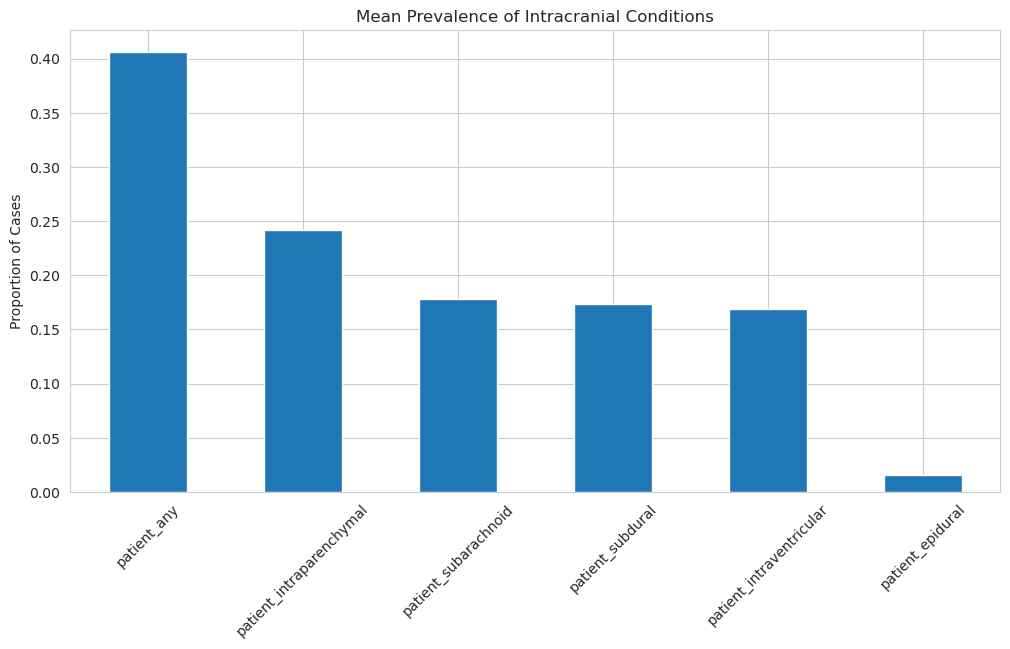

In [19]:
# Visualization
plt.figure(figsize=(12, 6))
patient_df.mean().sort_values(ascending=False).plot(
    kind='bar',
    title='Mean Prevalence of Intracranial Conditions',
    ylabel='Proportion of Cases'
)
plt.xticks(rotation=45)
plt.show()

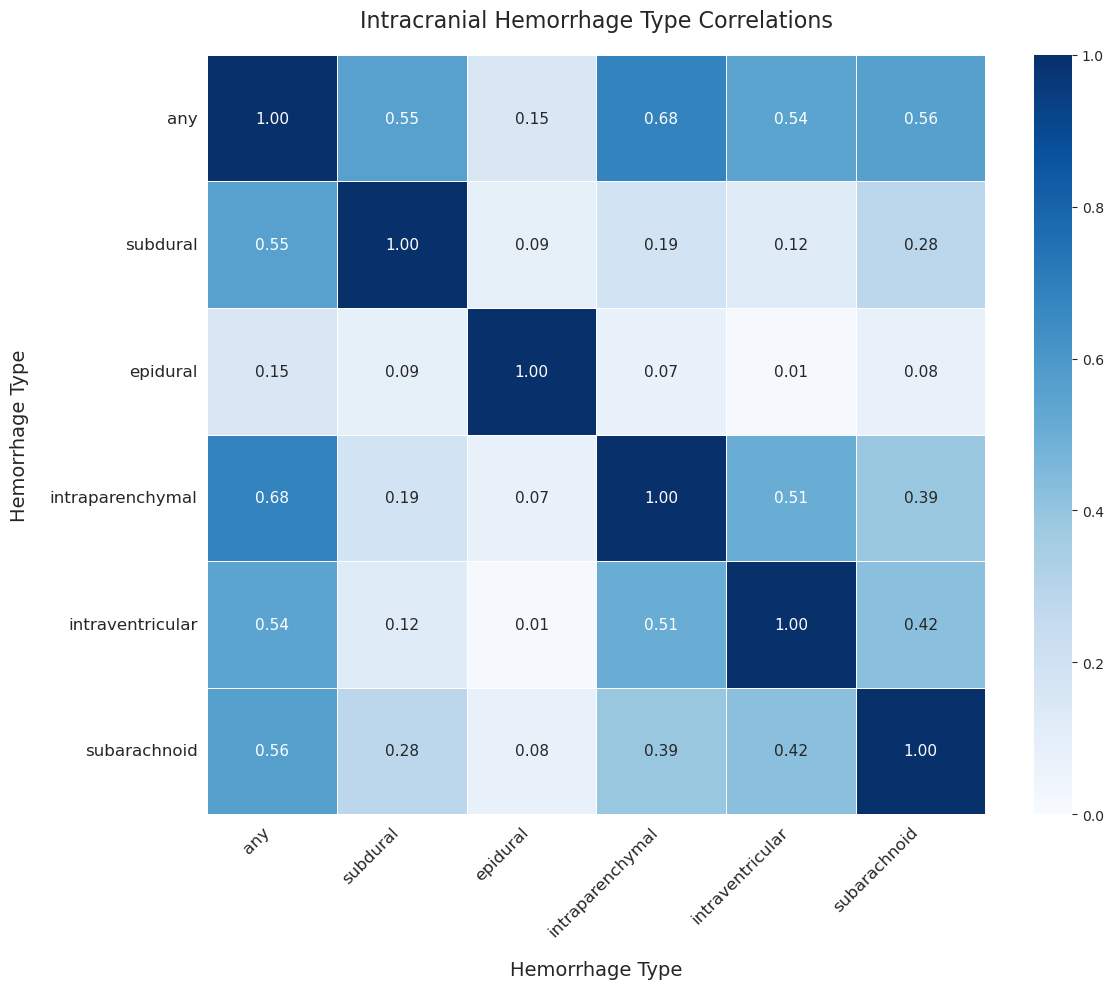

In [20]:
# Create correlation matrix with original columns
corr_matrix = df.filter(regex='^patient_(any|subdural|epidural|intraparenchymal|intraventricular|subarachnoid)').corr()

# Create renamed copy for visualization
plot_labels = [col.replace('patient_', '') for col in corr_matrix.columns]
df_plot = corr_matrix.set_axis(plot_labels, axis=1).set_axis(plot_labels, axis=0)

# Visualize with cleaned labels
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    df_plot,  # Use renamed dataframe
    annot=True,
    cmap='Blues', # Blues, Reds, coolwarm
    vmin=0,
    vmax=1,
    fmt=".2f",
    linewidth=0.5,
    annot_kws={"size": 11}
)

# Enhanced label formatting
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=12
)

plt.title("Intracranial Hemorrhage Type Correlations", fontsize=16, pad=20)
plt.xlabel("Hemorrhage Type", fontsize=14, labelpad=15)
plt.ylabel("Hemorrhage Type", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

TEST_SIZE = 0.15

def split_dataset_for_multilabel(patient_scan_labels, test_size=0.15, val_size=0.25, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels[['patient_any', 'patient_epidural', 'patient_intraparenchymal',
                                  'patient_intraventricular', 'patient_subarachnoid', 'patient_subdural']].values

    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(patient_scan_labels, labels))

        train_labels = patient_scan_labels.iloc[train_idx]
        test_labels = patient_scan_labels.iloc[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(train_labels, labels[train_idx]))

        train_labels_final = train_labels.iloc[train_idx]
        val_labels = train_labels.iloc[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(patient_scan_labels, labels))

        train_labels_final = patient_scan_labels.iloc[train_idx]
        val_labels = patient_scan_labels.iloc[val_idx]
        test_labels = None

    return train_labels_final, val_labels, test_labels

In [22]:
# import ast
#
# df = pd.read_csv('./data_analyze/training_dataset_1_redundancy.csv')
# # Parsing string columns into lists
# columns_to_parse = ['any', 'subdural', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid']
# for col in columns_to_parse:
#     df[col] = df[col].apply(ast.literal_eval)
#
# # Creating new columns with prefix 'patient_' based on the parsed data
# for col in columns_to_parse:
#     df[f'patient_{col}'] = df[col].apply(lambda x: int(any(x)))
# # Save to csv
# df.to_csv('./data_analyze/training_dataset_2_redundancy.csv', index=False)
#
# # Displaying the updated DataFrame
# df.head(10)

In [23]:
import pandas as pd

patient_scan_labels = pd.read_csv('./data_analyze/training_dataset_2_redundancy.csv')

train_labels, val_labels, test_labels = split_dataset_for_multilabel(patient_scan_labels, test_size=TEST_SIZE)

# Define new columns for hemorrhage types (these should be in your original DataFrame)
hemorrhage_columns = ['patient_any', 'patient_subdural', 'patient_epidural', 'patient_intraparenchymal', 'patient_intraventricular', 'patient_subarachnoid']

def count_hemorrhage_types(data):
    # Original counts for hemorrhage types
    counts = {col: data[col].sum() for col in hemorrhage_columns}
    unique_patients = {col: data[data[col] == 1].shape[0] for col in hemorrhage_columns}

    no_hem_count = (data[hemorrhage_columns].sum(axis=1) == 0).sum()

    counts['No Hemorrhage'] = no_hem_count
    unique_patients['No Hemorrhage'] = no_hem_count

    return counts, unique_patients

# Count for training set
train_counts, train_unique_patients = count_hemorrhage_types(train_labels)

# Count for validation set
val_counts, val_unique_patients = count_hemorrhage_types(val_labels)

# Count for test set
test_counts, test_unique_patients = count_hemorrhage_types(test_labels)

In [24]:
# Update summary data with new category
summary_data = {
    'Hemorrhage Type': hemorrhage_columns + ['No Hemorrhage'],
    'Train Counts': [train_counts[col] for col in hemorrhage_columns] + [train_counts['No Hemorrhage']],
    'Validation Counts': [val_counts[col] for col in hemorrhage_columns] + [val_counts['No Hemorrhage']],
    'Test Counts': [test_counts[col] for col in hemorrhage_columns] + [test_counts['No Hemorrhage']]
}

# Create a DataFrame for the summary table
summary_table = pd.DataFrame(summary_data)

# Display the summary table
summary_table

,Hemorrhage Type,Train Counts,Validation Counts,Test Counts
0,patient_any,5626,1876,1324
1,patient_subdural,2417,803,561
2,patient_epidural,223,74,52
3,patient_intraparenchymal,3350,1117,788
4,patient_intraventricular,2338,779,550
5,patient_subarachnoid,2464,822,580
6,No Hemorrhage,8229,2743,1937


In [25]:
# First get original counts
original_train_neg = train_counts['No Hemorrhage']
original_train_pos = train_counts['patient_any']

def balance_dataset(train_df, hemorrhage_col='patient_any'):
    """Undersamples negative cases to match positive case count"""
    # Split into positive/negative groups
    pos_cases = train_df[train_df[hemorrhage_col] == 1]
    neg_cases = train_df[train_df[hemorrhage_col] == 0]

    # Undersample negative cases
    neg_cases_sampled = neg_cases.sample(n=len(pos_cases),
                                       random_state=42,
                                       replace=False)

    # Combine and shuffle
    balanced_df = pd.concat([pos_cases, neg_cases_sampled]).sample(frac=1,
                                                                  random_state=42)
    return balanced_df

# Apply undersampling to training set only
balanced_train = balance_dataset(train_labels)

# Verify new counts
new_neg_count = balanced_train[balanced_train['patient_any'] == 0].shape[0]
new_pos_count = balanced_train[balanced_train['patient_any'] == 1].shape[0]

print(f"Original class ratio: {original_train_neg/original_train_pos:.1f}:1")
print(f"New class ratio: {new_neg_count/new_pos_count:.1f}:1")


Original class ratio: 1.5:1
New class ratio: 1.0:1


In [27]:
# Count for training set
train_counts, train_unique_patients = count_hemorrhage_types(balanced_train)

# Count for validation set
val_counts, val_unique_patients = count_hemorrhage_types(val_labels)

# Count for test set
test_counts, test_unique_patients = count_hemorrhage_types(test_labels)

# Update summary data with new category
summary_data = {
    'Hemorrhage Type': hemorrhage_columns + ['No Hemorrhage'],
    'Train Counts': [train_counts[col] for col in hemorrhage_columns] + [train_counts['No Hemorrhage']],
    'Validation Counts': [val_counts[col] for col in hemorrhage_columns] + [val_counts['No Hemorrhage']],
    'Test Counts': [test_counts[col] for col in hemorrhage_columns] + [test_counts['No Hemorrhage']]
}

# Create a DataFrame for the summary table
summary_table = pd.DataFrame(summary_data)

# Display the summary table
summary_table

,Hemorrhage Type,Train Counts,Validation Counts,Test Counts
0,patient_any,5626,1876,1324
1,patient_subdural,2417,803,561
2,patient_epidural,223,74,52
3,patient_intraparenchymal,3350,1117,788
4,patient_intraventricular,2338,779,550
5,patient_subarachnoid,2464,822,580
6,No Hemorrhage,5626,2743,1937
